# Track Comparison

And spatial skill assessments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

import modelskill as ms

## Extract track data

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.ModelResult(fn, name='HD', item=0)
mr

<DfsuModelResult> 'HD'

In this case, the track observations are stored in a csv file, which we can read in using pandas.
Any file format that can be read into a pandas dataframe can be used here.

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
df.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


In [5]:
mr.quantity

Quantity(name='Surface Elevation', unit='meter')

In [6]:
# the dataframe doesn't include the metadata on which quantity it contains, we add this manually, consistent with the model result
o1 = ms.TrackObservation(df, item="surface_elevation", name='alti', quantity=ms.Quantity(name="Surface Elevation", unit="meter")) 
o1

C:\Users\rywm\Repos\modelskill\modelskill\utils.py:134: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


TrackObservation: alti, n=1115

<Axes: title={'center': 'Spatial coverage'}>

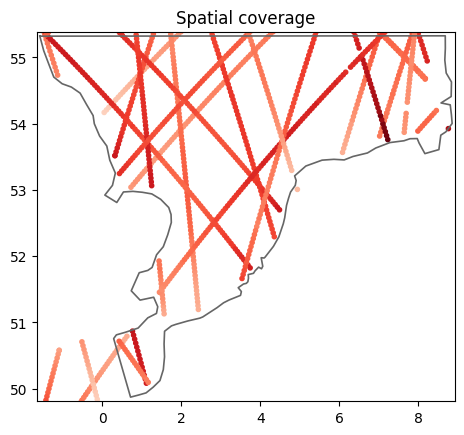

In [7]:
ms.plotting.spatial_overview(o1, mr)

In [8]:
cmp = ms.compare(o1, mr)
cmp

C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=544
 Model: HD, rmse=0.115

In [9]:
cmp.data

<xarray.Dataset>
Dimensions:      (time: 544)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-27T10:45:19 ... 2017-10-29T13:...
Data variables:
    x            (time) float64 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    HD           (time) float32 0.3699 0.356 0.3559 ... 0.7068 0.7068 0.685
    Observation  (time) float64 0.3778 0.4375 0.4489 ... 0.8562 0.8368 0.8218
Attributes:
    gtype:               track
    name:                alti
    quantity_name:       Surface Elevation
    modelskill_version:  1.0.dev2

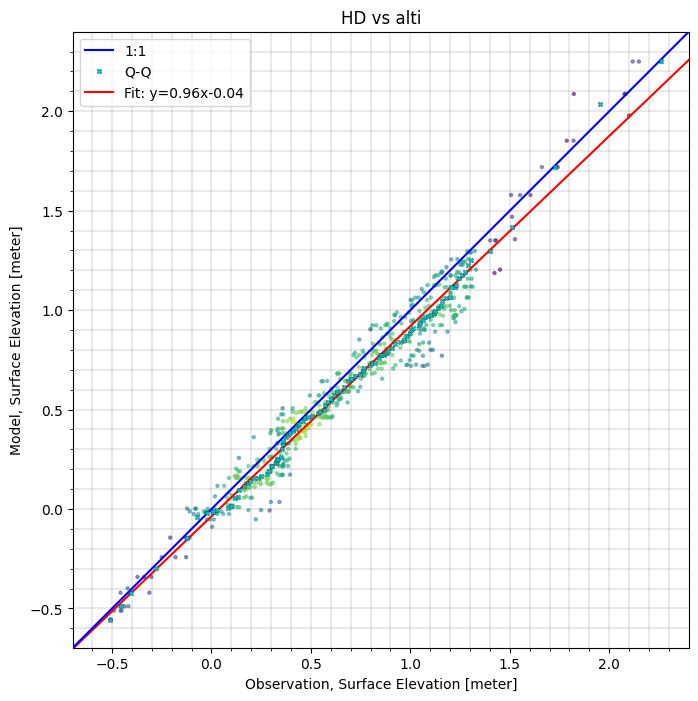

In [10]:
cmp.plot.scatter();

## Extract track from dfs0
ModelResult is now a dfs0

In [11]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ms.TrackModelResult(fn, name='HD', item=2)  # explicitly define type as Track
mr.data

C:\Users\rywm\Repos\modelskill\modelskill\utils.py:134: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


,x,y,Model_surface_elevation
2017-10-26 04:37:37,8.757272,53.926136,NaN
2017-10-26 04:37:54,8.221631,54.948460,NaN
2017-10-26 04:37:55,8.189390,55.008549,NaN
2017-10-26 04:37:56,8.157065,55.068626,NaN
2017-10-26 04:37:58,8.124656,55.128700,NaN
...,...,...,...
2017-10-30 20:54:43,3.703790,55.363529,NaN
2017-10-30 20:54:44,3.672147,55.420830,NaN
2017-10-30 20:54:45,3.640425,55.478127,NaN
2017-10-30 20:54:46,3.608623,55.535419,NaN


In [12]:
mr

<TrackModelResult> 'HD'

In [13]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')

C:\Users\rywm\Repos\modelskill\modelskill\utils.py:134: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


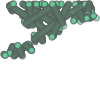

In [14]:
o1.geometry

In [15]:
o1.data

,x,y,surface_elevation
date,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449
2017-10-26 04:37:54,8.221631,54.948459,1.1200
2017-10-26 04:37:55,8.189390,55.008547,1.0882
2017-10-26 04:37:56,8.157065,55.068627,1.0309
2017-10-26 04:37:58,8.124656,55.128700,1.0369
...,...,...,...
2017-10-30 20:54:43,3.703790,55.363528,0.1111
2017-10-30 20:54:44,3.672147,55.420831,0.0647
2017-10-30 20:54:45,3.640425,55.478128,0.0364


In [16]:
cmp = ms.compare(o1, mr)

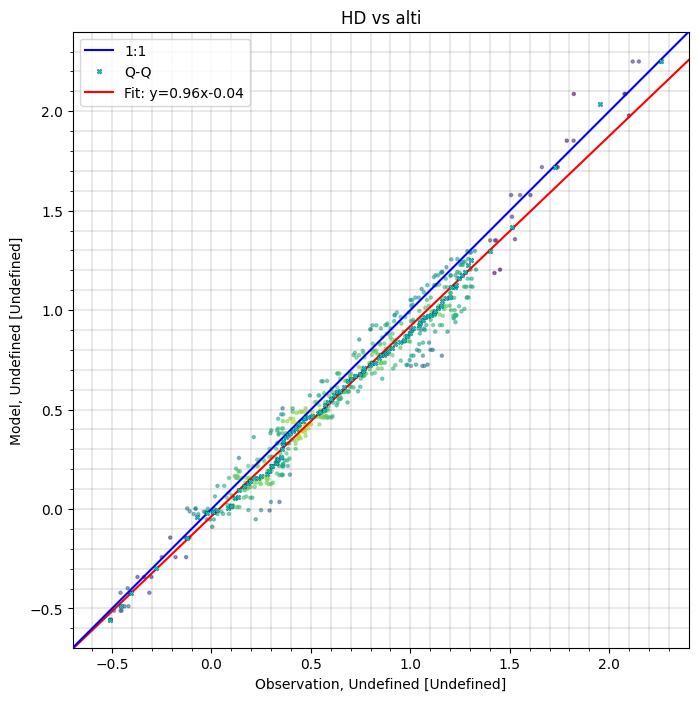

In [17]:
cmp.plot.scatter();

## Spatial skill

Load model, load observation, add observation to model and extract.

In [18]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.ModelResult(fn, name='HD', item=0)
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')
cmp = ms.compare(o1, mr)
cmp

C:\Users\rywm\Repos\modelskill\modelskill\utils.py:134: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(
C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


<Comparer>
Quantity: Undefined [Undefined]
Observation: alti, n_points=544
 Model: HD, rmse=0.115

Get metrics binned by a regular spatial grid, returns xarray Dataset

In [19]:
ss = cmp.spatial_skill(metrics=['bias'])

C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


In [20]:
ss.ds['n']

<xarray.DataArray 'n' (y: 5, x: 5)>
array([[ 3, 17,  0,  0,  0],
       [ 0, 50,  9,  0,  0],
       [ 0, 36, 51,  0,  0],
       [14, 72, 33, 15, 28],
       [37, 83,  0, 20, 76]])
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
    observation  <U4 'alti'
Attributes:
    long_name:  Number of observations
    units:      -

Plot using xarray - convenient methods coming soon!

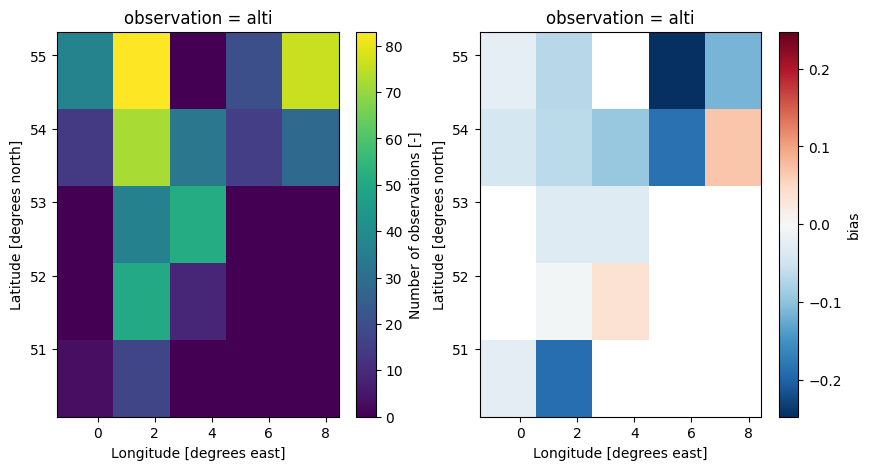

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Minimum number of observations

C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


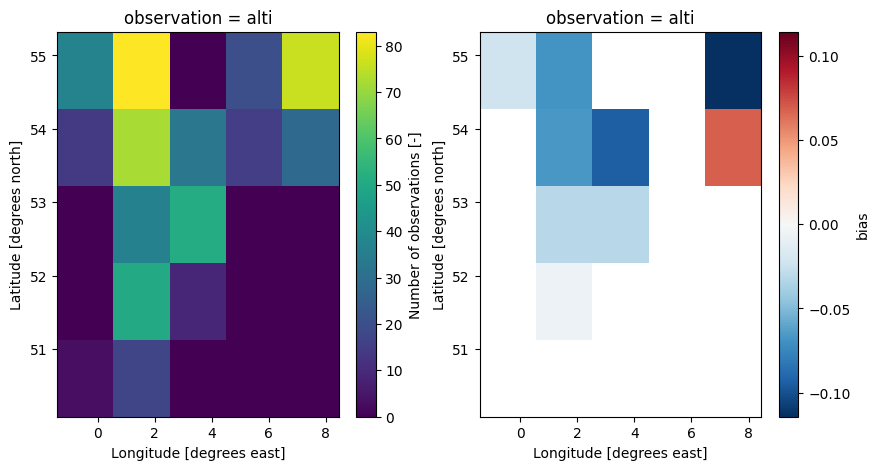

In [22]:
ss = cmp.spatial_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
ss.plot('n', ax=axes[0])
ss.plot('bias', ax=axes[1]);

## Multiple bins - spatial skill for water level categories

Get data from comparer as dataframe and add a water level category as a new column.

In [23]:
all_df = cmp.to_dataframe()
all_df["wl category"] = 'high'
all_df.loc[all_df['mod_val']<0, "wl category"] = 'low'

Add the "wl category" to the comparer's data structure.

In [24]:
cmp.data["wl category"] = all_df["wl category"]
cmp.data

<xarray.Dataset>
Dimensions:      (time: 544)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-27T10:45:19 ... 2017-10-29T13:...
Data variables:
    x            (time) float64 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    HD           (time) float32 0.3699 0.356 0.3559 ... 0.7068 0.7068 0.685
    Observation  (time) float64 0.3778 0.4375 0.4489 ... 0.8562 0.8368 0.8218
    wl category  (time) object 'high' 'high' 'high' ... 'high' 'high' 'high'
Attributes:
    gtype:               track
    name:                alti
    quantity_name:       Undefined
    modelskill_version:  1.0.dev2

Now aggregate the data by the new column (and x and y):

In [25]:
ss = cmp.spatial_skill(by=['wl category'], metrics=['bias'], n_min=5)
ss

C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


<xarray.Dataset>
Dimensions:      (y: 5, x: 5, wl category: 2)
Coordinates:
  * y            (y) float64 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 -0.436 1.543 3.517 5.492 7.466
  * wl category  (wl category) object 'high' 'low'
Data variables:
    n            (y, x, wl category) int32 0 3 14 3 0 0 0 0 ... 6 0 0 20 0 72 4
    bias         (y, x, wl category) float64 nan nan -0.2252 ... nan -0.1065 nan

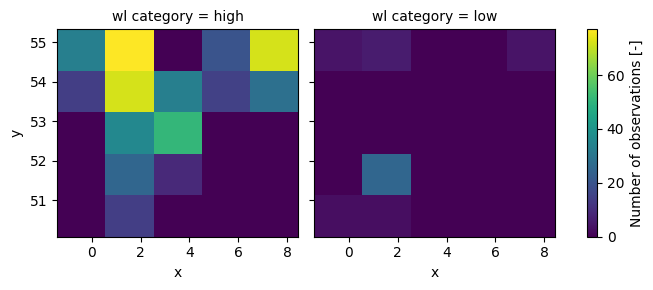

In [26]:
ss.plot('n');

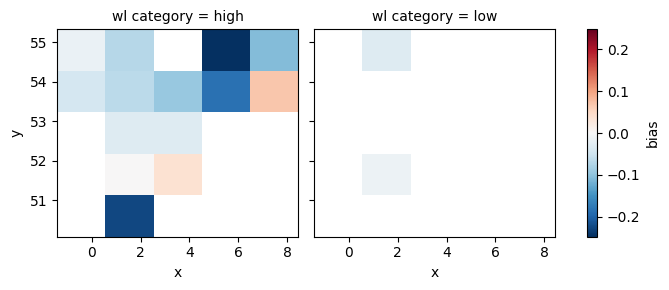

In [27]:
ss.plot('bias');

## Multiple observations

Add fake 2nd observation to model

In [28]:
df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = ms.TrackObservation(df2, item=2, name='alti2')
cmp2 = ms.compare(o2, mr)

C:\Users\rywm\Repos\modelskill\modelskill\utils.py:134: UserWarning: Time axis has duplicate entries. Now adding milliseconds to non-unique entries to make index unique.
  warnings.warn(


Extract, spatial skill, add attrs, plot.

C:\Users\rywm\Repos\modelskill\modelskill\comparison\_comparison.py:301: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df.groupby(by=by).apply(calc_metrics)


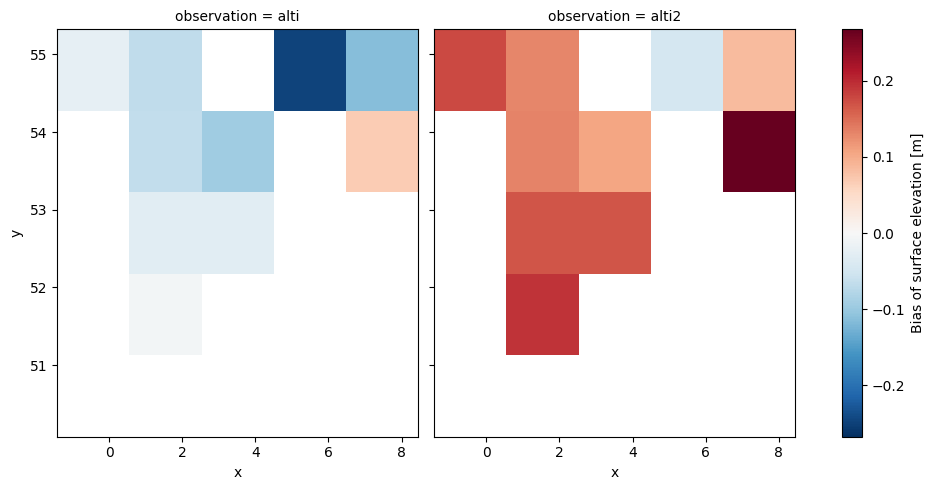

In [29]:
cc = cmp + cmp2
ss = cc.spatial_skill(metrics=['bias'], n_min=20)
ss.ds['bias'].attrs = dict(long_name="Bias of surface elevation", units="m")
ss.plot('bias', figsize=(10,5));